<a href="https://colab.research.google.com/github/worachot-n/Text_summarization_T5/blob/main/Text_Summarization_PrepareData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Data From Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import os
import time
import glob
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [3]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [11]:
!kaggle datasets download -d pariza/bbc-news-summary --unzip --force
# !kaggle datasets download -d pariza/bbc-news-summary

  0% 0.00/8.91M [00:00<?, ?B/s]
100% 8.91M/8.91M [00:00<00:00, 112MB/s]


In [13]:
%cd /content/drive/MyDrive/Kaggle/bbc-news-summary/BBC News Summary

/content/drive/MyDrive/Kaggle/bbc-news-summary/BBC News Summary


In [14]:
%ls

'BBC News Summary'/  'News Articles'/   Summaries/


In [34]:
os.listdir('/content/drive/MyDrive/Kaggle/bbc-news-summary/BBC News Summary/Summaries')

['business', 'entertainment', 'politics', 'sport', 'tech']

In [35]:
articles_path = '/content/drive/MyDrive/Kaggle/bbc-news-summary/BBC News Summary/News Articles'
summaries_path ='/content/drive/MyDrive/Kaggle/bbc-news-summary/BBC News Summary/Summaries'
categories_list = ['politics', 'sport', 'tech', 'entertainment', 'business']

In [38]:
def read_files_from_folders(articles_path,summaries_path,categories_list =['tech','sport'], encoding = "ISO-8859-1"):
    articles = []
    summaries = []
    categories = []
    for category in categories_list:
        article_paths =  glob.glob(os.path.join(articles_path , category , '*.txt'), recursive=True)
        summary_paths =  glob.glob(os.path.join(summaries_path , category , '*.txt'), recursive=True)

        print(f'found {len(article_paths)} file in articles/{category} folder, {len(summary_paths)} file in summaries/{category} folder')

        if len(article_paths) != len(summary_paths):
            print('number of files is not equal') 
            return    
        for idx_file in range(len(article_paths)):
            categories.append(category)
            with open(article_paths[idx_file], mode = 'r', encoding = encoding) as file:
                articles.append(file.read())


            with open(summary_paths[idx_file], mode = 'r', encoding = encoding) as file:
                 summaries.append(file.read())
    
    print(f'total {len(articles)} file in articles folders, {len(summaries)} file in summaries folders')
    return articles, summaries, categories

In [40]:
test_file = '/content/drive/MyDrive/Kaggle/bbc-news-summary/BBC News Summary/News Articles/business/001.txt'
with open(test_file, mode = 'r', encoding = "ISO-8859-1") as file:
    print(file.read())

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AO

In [39]:
articles, summaries, categories = read_files_from_folders(articles_path, summaries_path, categories_list)

found 417 file in articles/politics folder, 417 file in summaries/politics folder
found 511 file in articles/sport folder, 511 file in summaries/sport folder
found 401 file in articles/tech folder, 401 file in summaries/tech folder
found 386 file in articles/entertainment folder, 386 file in summaries/entertainment folder
found 510 file in articles/business folder, 510 file in summaries/business folder
total 2225 file in articles folders, 2225 file in summaries folders


In [41]:
df = pd.DataFrame({'articles':articles,'summaries': summaries, 'categories' : categories},)
df

,articles,summaries,categories
0,Escaped prisoner report ordered\n\nFirst Minis...,He held each of the major offices of chancello...,politics
1,Hospital suspends 'no Welsh' plan\n\nAn Englis...,Tony Blair is likely to name 5 May as election...,politics
2,'No-one can define new hunt ban'\n\nThe new la...,Tory co-chairman Liam Fox has opened proceedin...,politics
3,Police urge pub closure power\n\nNew powers ar...,Labour election coordinator Alan Milburn claim...,politics
4,Blunkett tells of love and pain\n\nDavid Blunk...,"In a statement, he said abortion was a ""very k...",politics
...,...,...,...
2220,GE sees 'excellent' world economy\n\nUS behemo...,The WTO said that many developing countries su...,business
2221,Millions 'to lose textile jobs'\n\nMillions of...,Reuters news agency reported that Iraq's Oil M...,business
2222,US to rule on Yukos refuge call\n\nYukos has s...,Parmalat has sued 45 banks as it tries to recl...,business
2223,Business confidence dips in Japan\n\nBusiness ...,Bombardier said restructuring plans drawn up b...,business


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   articles    2225 non-null   object
 1   summaries   2225 non-null   object
 2   categories  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [44]:
df.head()

,articles,summaries,categories
0,Escaped prisoner report ordered\n\nFirst Minis...,He held each of the major offices of chancello...,politics
1,Hospital suspends 'no Welsh' plan\n\nAn Englis...,Tony Blair is likely to name 5 May as election...,politics
2,'No-one can define new hunt ban'\n\nThe new la...,Tory co-chairman Liam Fox has opened proceedin...,politics
3,Police urge pub closure power\n\nNew powers ar...,Labour election coordinator Alan Milburn claim...,politics
4,Blunkett tells of love and pain\n\nDavid Blunk...,"In a statement, he said abortion was a ""very k...",politics


In [45]:
df.to_csv('/content/drive/MyDrive/Kaggle/BBC_News_Summary.csv')  

In [47]:
#-- get length of each article and summary for analysis
df['articles_length'] = df['articles'].apply(lambda x : len(x.split()))
df['summaries_length'] = df['summaries'].apply(lambda x : len(x.split()))

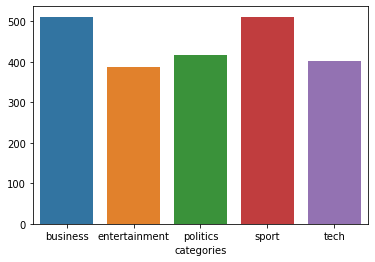

In [48]:
category_sizes = df.groupby('categories').size()
sns.barplot(x=category_sizes.index, y= category_sizes)
plt.show()

In [49]:
category_length = df.groupby('categories',0).agg( {'articles_length':'mean', 'summaries_length':'mean'} )
category_length

,articles_length,summaries_length
categories,,
business,328.880392,139.929412
entertainment,330.621762,144.049223
politics,453.973621,195.709832
sport,329.262231,143.187867
tech,502.695761,213.837905


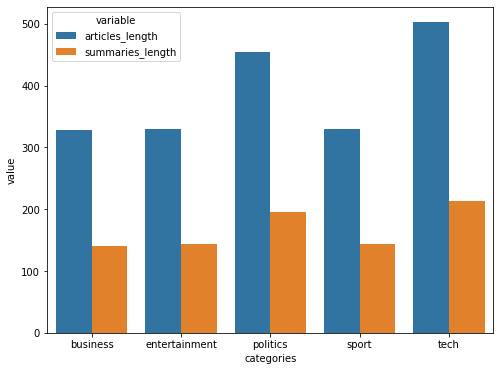

In [50]:
category_length = df.groupby('categories',0).agg( {'articles_length':'mean', 'summaries_length':'mean'} )
df_m = pd.melt(category_length,ignore_index=False)

sns.barplot(x=df_m.index, y="value",hue='variable', data= df_m)
plt.show()

In [51]:
pd.melt(category_length,ignore_index=False).groupby('variable').mean()

,value
variable,
articles_length,389.086753
summaries_length,167.342848


In [52]:
import spacy
#!python -m spacy download en_core_web_sm 

In [53]:
spacy_eng = spacy.load('en_core_web_sm')

In [54]:
def tokenizer_eng(text, max_length = 100):
    return [tok.text for tok in spacy_eng.tokenizer(text)] 

In [55]:
def pad_sequence(sequence, max_length = 100):
    max_length -= 2
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
        return ['<sos>'] + sequence + ['<eos>']
    else:
        sequence = sequence + ['<pad>'] * (max_length - len(sequence))
        return ['<sos>'] + sequence + ['<eos>']

In [56]:
#-- for building vocab via torchtext we need iterator
def data_iter():
    for article in df['articles']:
        yield tokenizer_eng(article)

In [57]:
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [60]:
news_vocab = build_vocab_from_iterator(data_iter(), min_freq = 2, specials=special_symbols, special_first=True)
news_vocab.set_default_index(news_vocab["<unk>"])
len(news_vocab)

22191

In [61]:
news_vocab(['<unk>', '<pad>', '<sos>', '<eos>','hello','there','a','the'])

[0, 1, 2, 3, 20572, 81, 11, 4]